## 1-D Time Indipendent Schrodinger Equation
For simplycity we take all numerical constants equal to one

$$\Large -\frac{d^2 \psi(x)}{dx^2} + V(x)\psi(x) = E\psi(x) $$

This problem can be restated as a system of ODE:

$$\large \frac{d \psi_1(x)}{dx} = \psi_2(x)$$
$$\large \frac{d \psi_2(x)}{dx} = -(E - V(x))\psi_1(x)$$

Scipy's ```solve_bvp``` needs boundary conditions in the form $\psi(x_1) = \psi(x_2) = 0$ for some $x_1$ and $x_2 \in [a,b]$, where $a$ and $b$ are the extremes of the integration domain. This somewhat restricts the range of possible problems we can approach wth this method.

Another problem is that we need to give the value of $E$ in advance. We can proceed with an iterative method: we define an interval $[E_{min}, E_{max}]$ in which we can reasonably expect to find the real energy of the solution. The trial energy is taken as the midpoint of the interval. We then solve the problem iteratively, adjusting the trial energy in a bisection-like manner, until the resulting wavefunction has exactly as many nodes as $n$ (the order of the solution we are interested in), a result known as "Node Theorem". The computational complexity of such a procedure is of course logarithmic in energy trials.

In [10]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import numpy as np
from scipy.signal import argrelextrema, argrelmin


def V(x, V0=50, a=1):
    if np.iterable(x):
        return (np.abs(x) > a/2)*V0
    elif np.abs(x) < a/2:
        return 0
    else:
        return V0

def fun(x, y, p):
    E = p[0]
    return np.vstack((y[1], -2*(E - V(x))*y[0]))

def bc(ya, yb, p):
    return np.array([ya[0], yb[0], ya[1] - 0.001])


x = np.linspace(-1.5, 1.5, 11)
x_plot = np.linspace(-1.5, 1.5, 2000)
y_i = np.zeros((2, x.size))
y_i[0,4] = 0.1

E_min = 0.
E_max = 4.

energies = []

for n in range(1,11):
    converged = False
    prec_E = 0.

    while not converged:
        E = (E_min + E_max)*0.5
        sol = solve_bvp(fun, bc, x, y_i, p=[E])
        try:
            res = argrelmin(sol.sol(x_plot)[0]**2)[0]
            res[0]
            n_nodes = len(res) + 1
        except:
            n_nodes = 1

        if n_nodes == n:
            energies.append(sol.p[0])
            converged = True
            print('Level',n, 'Energy', sol.p[0])
        elif n_nodes > n:
            E_max = E
        elif n_nodes < n:
            E_min = E
        
        if np.abs(prec_E - E) < 1e-2:
            if prec_E - E < 0:
                E_max = energies[-1]**2.5
            else:
                E_min = energies[-1]
        
        #print(E,n,n_nodes, prec_E  -E)
        prec_E = E
    E_min = energies[-1]
    E_max = E_min ** 2.5

        


'''sol = solve_bvp(fun, bc, x, y_i, p=[6])
x_plot = np.linspace(-1.5, 1.5, 2000)
y_plot = sol.sol(x_plot)[0]

plt.plot(x_plot, y_plot**2)
plt.xlabel("x")
plt.ylabel("y")
plt.show()'''

Level 1 Energy 3.4136405339674374
Level 2 Energy 13.476083439057865
Level 3 Energy 29.45443173473915
Level 4 Energy 48.260942644843915
Level 5 Energy 54.49322973517068
Level 6 Energy 57.48796764560538
Level 7 Energy 66.18938749607112
Level 8 Energy 73.06436315455764
Level 9 Energy 82.17142054325815
Level 10 Energy 99.02187116406185


'sol = solve_bvp(fun, bc, x, y_i, p=[6])\nx_plot = np.linspace(-1.5, 1.5, 2000)\ny_plot = sol.sol(x_plot)[0]\n\nplt.plot(x_plot, y_plot**2)\nplt.xlabel("x")\nplt.ylabel("y")\nplt.show()'

However, this method fails because the number of nodes does not behave in a precise enough manner: our dicotomic search suffer from the fact that the number of nodes does not increase monotonically as the energy increases, leading to "traps" where the correct energy is never reached. This can be circumvencted by modifying the $E_{min}$ and $E_{max}$ update procedures.
However, it is necessary to try a more robust (nad hopefully efficient) method to find the correct energy eigenvalue.

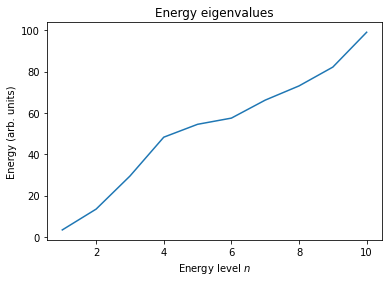

In [13]:
plt.plot(list(range(1,11)),energies)

plt.xlabel('Energy level $n$')
plt.ylabel('Energy (arb. units)')
plt.title('Energy eigenvalues')
plt.show()